# CLV using lifetimes package

## Load data

In [7]:
import lifetimes
%matplotlib inline

In [3]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


## Terminology

https://dataorigami.net/blogs/napkin-folding/18868411-lifetimes-measuring-customer-lifetime-value-in-python

- T corresponds to the time between their first purchase and now (their “lifetime” as a customer of yours). 
- t_x is the time when they made their last purchase, relative to their age. 

For example, if a customer bought an item from you 5 years ago, and 2 years ago, then T=5 and t_x = 5 – 2 = 3.

http://lifetimes.readthedocs.io/en/latest/Quickstart.html

- frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

## BG/NBD model

### Init

In [5]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.1) # L2 regularizer for small sample size. 
                                        # In typical applications, 0.001 to 0.1 are effective.

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.13, alpha: 4.22, b: 0.27, r: 0.23>


### Fit model

In [26]:
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.13, alpha: 4.22, b: 0.27, r: 0.23>


### Frequency/Recency matrix
Expected number of transactions a customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made)

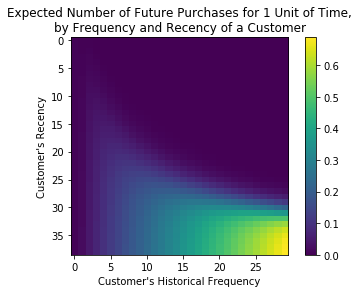

In [9]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf);

Coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

### Ranking customers
Rank customer based on the expected purchases in the next period

In [10]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.449462
841,19,34.00,34.14,0.496724
1981,17,28.43,28.86,0.514758
157,29,37.71,38.00,0.687468
1516,26,30.86,31.00,0.739235


### Assess model fit

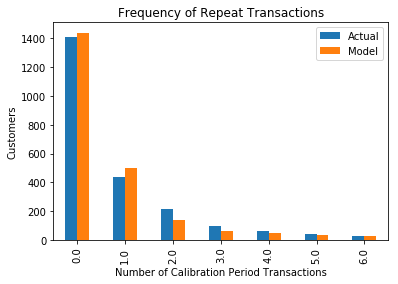

In [12]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf);

### Transactional dataset

In [13]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


#### Preprocessing
Transform the transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [14]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


#### Init

In [18]:
bgf = BetaGeoFitter(penalizer_coef=0.1)

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.47, alpha: 1.83, b: 0.48, r: 0.16>

#### Fit model

In [27]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.47, alpha: 1.83, b: 0.48, r: 0.16>

#### Split data into calibration and holdout sets

In [19]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


#### Assess model fit

/home/kaushik/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:183: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
/home/kaushik/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:187: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


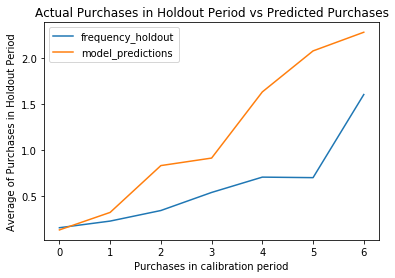

In [20]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

#### Cumulative purchase prediction for any individual customers for next n periods

In [21]:
t = 10 # Predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.072714864097510809

#### Probability of a customer being alive

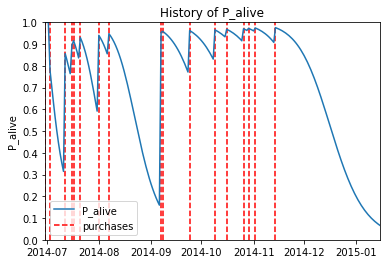

In [23]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date');

## Gamma/Gamma model
Take into account the economic value of each transaction

### Preprocessing
First create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [24]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


### Check assumptions
Gamma/Gamma model assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [25]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


### Fit model

In [28]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

### Estimate conditional expectations for individual customers

In [31]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658620
2     18.911491
3     35.170997
4     35.170997
5     35.170997
6     71.462845
7     18.911491
8     35.170997
9     27.282410
10    35.170997
dtype: float64
Expected conditional average profit: 35.25295516381743, Average profit: 35.07855179704026


### Estimate conditional expectations for all customers in aggregation

In [32]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))


Expected conditional average profit: 35.25295516381743, Average profit: 35.07855179704026


### Adjust for cost of capital using DCF method

In [33]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, # the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      296.562019
2       21.818107
3             NaN
4             NaN
5             NaN
6     2958.020770
7       33.829708
8             NaN
9      341.229888
10            NaN
Name: clv, dtype: float64


/home/kaushik/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:183: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
/home/kaushik/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:187: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


## Save model

In [34]:
bgf.save_model('tmp/bgf.pkl')

## Load model

In [35]:
bgf_loaded = BetaGeoFitter(penalizer_coef=0.1)
bgf_loaded.load_model('tmp/bgf.pkl')
bgf_loaded

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.13, alpha: 4.22, b: 0.27, r: 0.23>

## SQL databse

http://lifetimes.readthedocs.io/en/latest/More%20examples%20and%20recipes.html